In [23]:
import numpy as np
from sklearn.metrics import roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib.pyplot as plt
import cPickle

# Score-combinations for Phonemes

In [24]:
def create_dir(dir_name):
	try:
		os.makedirs(dir_name)
	except OSError as exception:
		if exception.errno != errno.EEXIST:
			raise

In [84]:
base_dir = "/Users/lmatayoshi/Documents/Projects/tesis_notebooks/kappa_experiments/all_phonemes_experiment/heldout/"
score_combination_dir = base_dir + "score_combination/single/"
features_combination_dir = base_dir + "features_combination/single/"
output_dir = base_dir + "output/"
output_histograms_dir = output_dir + "histograms/"
output_histograms_score_combination_dir = output_histograms_dir + "score_combination/"
output_histograms_feature_combination_dir = output_histograms_dir + "features_combination/"

In [69]:
phonemes = ['N', 'rr', 'u', 'y', 'l', 'n']

In [70]:
def load_heldout_speakers():
	speakers_filename = base_dir + "heldout_speakers"
	with open(speakers_filename, "r") as f:
		speakers = [line.rstrip() for line in f.readlines()]
	return speakers

In [71]:
def all_phonemes_empty_dict(phonemes):
    return dict(zip(phonemes, [[] for p in phonemes]))

In [72]:
def phonemes_positives_negatives_dict():
    phonemes = ['N', 'rr', 'u', 'y', 'l', 'n']
    #total_values = [865, 923, 1243, 1597, 2929, 3920, 6167, 8035]
    #total_dict = dict(zip(phonemes, total_values))
    positives_values = [246, 528, 743, 428, 920, 3234, 4929, 7555]
    positives_dict = dict(zip(phonemes, positives_values))
    negatives_values = [116, 395, 500, 1169, 2009, 686, 1238, 480]
    negatives_dict = dict(zip(phonemes, negatives_values))
    total_values = [positives_values[i] + negatives_values[i] for i in range(len(positives_values))]
    total_dict = dict(zip(phonemes, total_values))
    return (total_dict, positives_dict, negatives_dict)

In [73]:
def check_logids(lines_supervectors, lines_second_source):
    logids_supervectors = [l[0] for l in lines_supervectors]
    logids_second_source = [l[0] for l in lines_second_source]
    if not logids_supervectors == logids_second_source:
        raise Exception(phoneme + " logids doesn't match in supervectors vs second source")
    

In [74]:
def label_for(label):
    if label == "True":
        return 1
    elif label == "False":
        return -1

In [75]:
def compute_EER(tuples):
    labels = [t[1] for t in tuples]
    hyperplane_distances = [t[0] for t in tuples]
    fpr, tpr, _ = roc_curve(labels, hyperplane_distances)
    # eer is where fpr is equal to fnr
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    return eer

In [76]:
def lines_for_speaker(lines, speaker):
    return [line for line in lines if speaker in line[0]]

In [77]:
def generate_shuffled_speakers_list(speakers, n):
    res = []
    for i in range(n):
        res.append(shuffled_with_replacement(speakers))
    return res

In [78]:
def shuffled_with_replacement(speakers):
	n_speakers = len(speakers)
	shuffled_indexes_with_replacement = np.random.randint(n_speakers, size=n_speakers)
	return [speakers[j] for j in shuffled_indexes_with_replacement]

Estrategia: 2 experimentos de score combination. Uno para supervectors_legendre y otro para supervectors_dct.
Para cada fonema, combino scores de ambos tips de features utilizando como factor el diccionario pasado por parámetro.
Modificar la lista original agregando a las tuplas los de cada speaker, una vez que genero los phoneme values

In [42]:
def main(eers_dir, second_source, proportion_dict):
    ### Dictionary generation 
    heldout_speakers = load_heldout_speakers()
    shuffled_speakers_list = generate_shuffled_speakers_list(heldout_speakers, 1000)
    res = all_phonemes_empty_dict(phonemes)
    supervectors_dir = eers_dir + "supervectors/"
    second_source_dir = eers_dir + second_source + "/"
    for phoneme in phonemes:
        original_phoneme = phoneme
        if phoneme in ['g', 'y', 'd', 'b', 'n']:
            phoneme = phoneme + "_lowercase"
        supervectors_filename = supervectors_dir + phoneme
        second_source_filename = second_source_dir + phoneme
        with open(supervectors_filename, "r") as f_supervectors:
            lines_supervectors = f_supervectors.readlines()
            lines_supervectors = [l.split(" ") for l in lines_supervectors]
        with open(second_source_filename, "r") as f_second_source:
            lines_second_source = f_second_source.readlines()
            lines_second_source = [l.split(" ") for l in lines_second_source]
        check_logids(lines_supervectors, lines_second_source)
        
        for speakers in shuffled_speakers_list:
            new_lines_supervectors = []
            new_lines_second_source = []
            for speaker in speakers:
                new_lines_supervectors = new_lines_supervectors + lines_for_speaker(lines_supervectors, speaker)
                new_lines_second_source = new_lines_second_source + lines_for_speaker(lines_second_source, speaker)
            check_logids(new_lines_supervectors, new_lines_second_source)
            
            phoneme_values = []
            for i in range(len(new_lines_supervectors)):
                new_value = float(new_lines_supervectors[i][4]) + proportion_dict[original_phoneme]*float(new_lines_second_source[i][4])
                new_line = new_lines_supervectors[i]
                label = label_for(new_line[3])
                new_tuple = (new_value, label)
                #new_line[4] = str(new_value)
                #new_line = " ".join(new_line) + "\n"
                phoneme_values.append(new_tuple)
            res[original_phoneme].append(compute_EER(phoneme_values))
    
    return res

In [52]:
def main_single_source(eers_dir, features_combination_type='supervectors'):
    ### Dictionary generation 
    heldout_speakers = load_heldout_speakers()
    shuffled_speakers_list = generate_shuffled_speakers_list(heldout_speakers, 1000)
    res = all_phonemes_empty_dict(phonemes)
    supervectors_dir = eers_dir + features_combination_type + "/"
    for phoneme in phonemes:
        original_phoneme = phoneme
        if phoneme in ['g', 'y', 'd', 'b', 'n']:
            phoneme = phoneme + "_lowercase"
        supervectors_filename = supervectors_dir + phoneme
        with open(supervectors_filename, "r") as f_supervectors:
            lines_supervectors = f_supervectors.readlines()
            lines_supervectors = [l.split(" ") for l in lines_supervectors]
        
        for speakers in shuffled_speakers_list:
            new_lines_supervectors = []
            for speaker in speakers:
                new_lines_supervectors = new_lines_supervectors + lines_for_speaker(lines_supervectors, speaker)
            
            phoneme_values = []
            for i in range(len(new_lines_supervectors)):
                new_value = float(new_lines_supervectors[i][4]) 
                new_line = new_lines_supervectors[i]
                label = label_for(new_line[3])
                new_tuple = (new_value, label)
                #new_line[4] = str(new_value)
                #new_line = " ".join(new_line) + "\n"
                phoneme_values.append(new_tuple)
            res[original_phoneme].append(compute_EER(phoneme_values))
    
    return res

In [37]:
factors_dct_dict = {
    'N': 1.0,
    'rr': 0.9,
    'u': 1.0,
    'y': 1.0,
    'l': 0.8,
    'n': 0.7
}

## Loading pickles

In [19]:
pickle_dir = base_dir + "pickles/"
score_combination_pickles_dir = pickle_dir + "score_combination/"

In [64]:
with open(score_combination_pickles_dir + "supervectors_dct", "rb") as f:
    supervectors_dct = cPickle.load(f)

In [65]:
with open(score_combination_pickles_dir + "supervectors", "rb") as f:
    supervectors = cPickle.load(f)

In [43]:
#supervectors_dct = main(score_combination_dir, "dct", factors_dct_dict)

In [53]:
#supervectors = main_single_source(score_combination_dir)

### Features combination

In [79]:
features_combination_supervectors_dct = main_single_source(features_combination_dir, "supervectors_dct")

# Score combination analysis

In [66]:
for phoneme in phonemes:
    print "Phoneme: " + phoneme
    print "Supervectors: " + str(np.mean(supervectors[phoneme]))
    print "Supervectors + DCT: " + str(np.mean(supervectors_dct[phoneme]))
    print "\n"

Phoneme: N
Supervectors: 0.205413913854
Supervectors + DCT: 0.20951788916


Phoneme: rr
Supervectors: 0.338850353659
Supervectors + DCT: 0.336499517649


Phoneme: u
Supervectors: 0.350699667129
Supervectors + DCT: 0.336730686419


Phoneme: y
Supervectors: 0.364436216874
Supervectors + DCT: 0.34970381662


Phoneme: l
Supervectors: 0.288649055547
Supervectors + DCT: 0.277236280588


Phoneme: n
Supervectors: 0.378176046237
Supervectors + DCT: 0.368427166047




# Feature combination analysis

In [80]:
for phoneme in phonemes:
    print "Phoneme: " + phoneme
    print "Supervectors: " + str(np.mean(supervectors[phoneme]))
    print "Supervectors + DCT: " + str(np.mean(features_combination_supervectors_dct[phoneme]))
    print "\n"

Phoneme: N
Supervectors: 0.205413913854
Supervectors + DCT: 0.196089306321


Phoneme: rr
Supervectors: 0.338850353659
Supervectors + DCT: 0.338283054413


Phoneme: u
Supervectors: 0.350699667129
Supervectors + DCT: 0.354752085645


Phoneme: y
Supervectors: 0.364436216874
Supervectors + DCT: 0.346353166567


Phoneme: l
Supervectors: 0.288649055547
Supervectors + DCT: 0.26827061069


Phoneme: n
Supervectors: 0.378176046237
Supervectors + DCT: 0.381295395478




# Histograms

In [57]:
def text_for_delta(number):
    if number < 0:
        return "improvement"
    else:
        return "degradation"

In [90]:
def plot_and_save_histogram(supervectors, score_combination, label, phoneme, output_dir=None):
    if phoneme in ['g', 'y', 'd', 'b', 'n']:
        output_phoneme = phoneme + "_lowercase"
    else:
        output_phoneme = phoneme
    n_bins = 30
    #counts_positives_negatives, bins_positives_negatives, patches_positives_negatives = plt.hist(positives_negatives_distances, n_bins)
    counts_both, bins_both, _ = plt.hist(supervectors + score_combination, n_bins)

    ################
    # SUPERVECTORS # 
    ################

    n_supervectors, bins_supervectors, _ = plt.hist(supervectors, bins=bins_both)
    plt.clf()
    #normalized_positives = n_positives/total_positives

    #####################
    # SCORE COMBINATION #
    #####################

    n_score_combination, bins_score_combination, _ = plt.hist(score_combination, bins=bins_both)
    #normalized_negatives = n_negatives/total_negatives

    fixed_bins = []
    for i in range(0, len(bins_both) - 1):
        mean = (bins_both[i] + bins_both[i+1]) / 2
        fixed_bins.append(mean)

    plt.clf()
    
    supervectors_mean = np.mean(supervectors)
    combination_mean = np.mean(score_combination)
    delta = (combination_mean - supervectors_mean) / supervectors_mean
    delta_text = "%.2f" % np.abs(delta) + "% " + text_for_delta(delta)
    plt.title("Phoneme: " + phoneme + ", " + delta_text )
    plt.plot(fixed_bins, n_supervectors, color="blue", label="supervectors")   
    plt.plot(fixed_bins, n_score_combination, color="red", label= label)
    plt.axvline(x=supervectors_mean, linestyle="--", linewidth=0.5, color="blue")
    plt.axvline(x=combination_mean, linestyle="--", linewidth=0.5, color="red")
    plt.legend()
    plt.xticks(fixed_bins, rotation='vertical')
    plt.tight_layout()
    plt.xlabel("EER")
    plt.ylabel("count")
    if output_dir:
        plt.savefig(output_dir + output_phoneme)
    plt.show()


# Score combination histograms

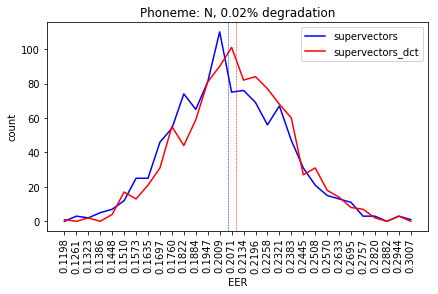

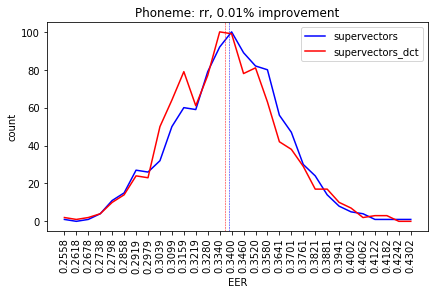

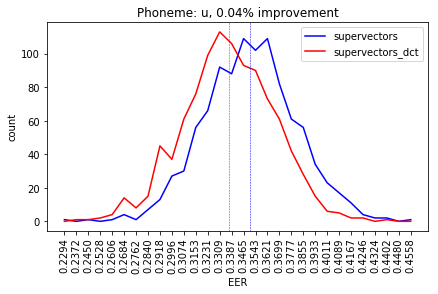

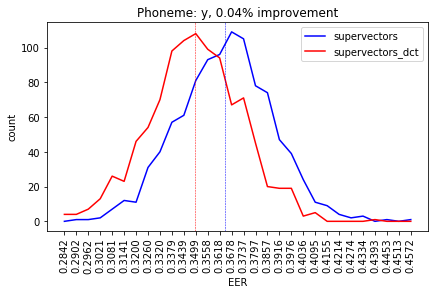

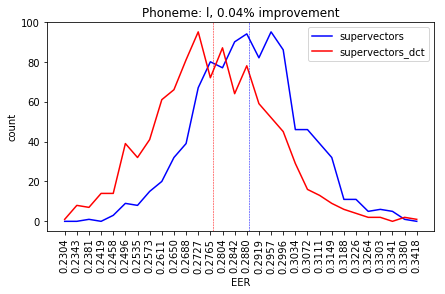

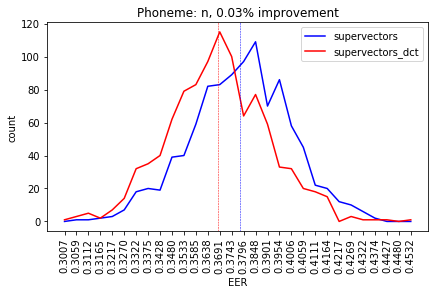

In [91]:
for phoneme in phonemes:
    plot_and_save_histogram(supervectors[phoneme], supervectors_dct[phoneme], "supervectors_dct", phoneme, output_histograms_score_combination_dir)

# Features combination histograms

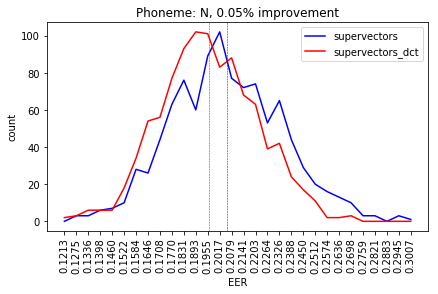

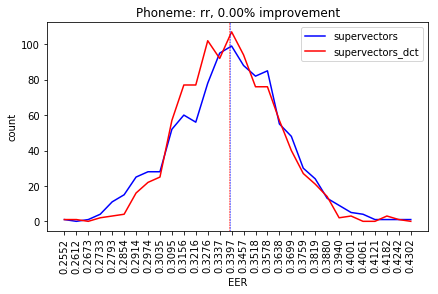

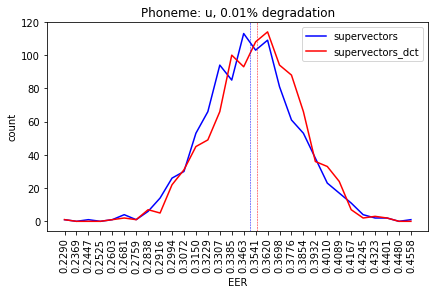

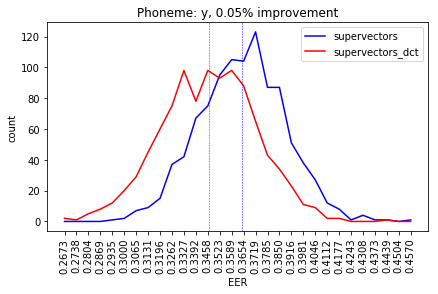

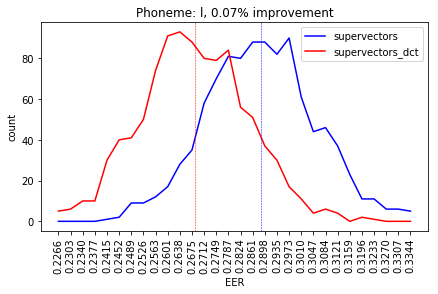

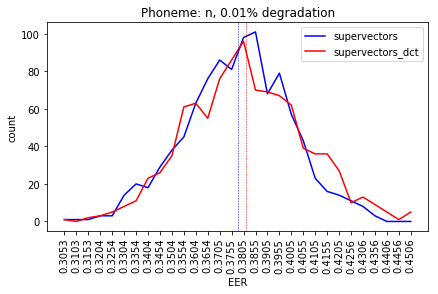

In [92]:
for phoneme in phonemes:
    plot_and_save_histogram(supervectors[phoneme], features_combination_supervectors_dct[phoneme], "supervectors_dct", phoneme, output_histograms_feature_combination_dir)